<a href="https://colab.research.google.com/github/braveenth/garmin-running-llm/blob/main/Garmin_Running_LLM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Garmin Running LLM Analysis 🏃
By: Braveenth Rasanayagam

---

The goal of this Jupyter Notebook is to have reuseable code that facilitates the prompting and analysis of your your Garmin-tracked runs by LLMs.

This was built to help train for a half-marathon, and you can use it for your fitness activities.

I solved the context length limitations imposed by various LLM models by splitting the data using even rows, which is a method to reduce the number of data points. I am also considering other mathematical methods of reducing the number of data points.

Please note that I am not responsible or liable for your use of this application. Please use this at your own risk and consult with a health care professional.


## Steps to Use:
Using OpenAI's ChatGPT API:

1.   Obtain an OpenAI API Key here: https://platform.openai.com/api-keys
2.   Add OpenAI API Key as a Colab secret value named 'OPENAI_API_KEY'
3.   Obtain .fit file from Garmin Connect
4.   Upload .fit file to Colab files
5.   Specify path to .fit file in notebook form

## Steps to Contribute:
Submit a pull-request or message me!
MIT License

## Additional Links
*   [runw.ai](https://www.runw.ai/)
*   [Instagram - runw.ai](https://www.instagram.com/runw.ai.run/)


In [1]:
!pip install garmin-fit-sdk
!pip install tiktoken
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.5/234.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.4/227.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.5 MB/s eta 0:00:00


In [2]:
# Lets start by obtaining the path to the .fit file
fit_file = "/content/14041604082_ACTIVITY.fit" # @param {type:"string"}

In [3]:
# Lets describe an existing run that I have completed. We will use the fit file from Garmin Connect.
# In the future, we will retrieve this using Garmin's API.
# Lets use the garmin-fit-sdk here

from garmin_fit_sdk import Decoder, Stream

stream = Stream.from_file(fit_file)
decoder = Decoder(stream)
messages, errors = decoder.read()

print(errors)
# print(messages)

[]


In [4]:
file_messages = messages['file_id_mesgs']

duration_of_activity = messages['activity_mesgs'][0]['total_timer_time']
activity_record_messages = messages['record_mesgs']

# for activity_message in activity_record_messages:
#   print(activity_message)
#print(messages['user_profile_mesgs'])
#print(messages['file_id_mesgs'])

# Information about the units
# 'distance' - metres

In [7]:
# Lets get this information into a Pandas Dataframe

import pandas as pd

df = pd.DataFrame(activity_record_messages)
# Lets remove columns that are currently not necessary

df_with_relevant_information = df.drop(['cycle_length16', 'enhanced_speed','fractional_cadence', 135, 136], axis=1)
display(df_with_relevant_information)

,timestamp,distance,heart_rate,cadence,temperature
0,2024-02-19 19:50:40+00:00,0.00,116,0,26
1,2024-02-19 19:50:41+00:00,0.00,114,0,26
2,2024-02-19 19:50:43+00:00,0.00,117,0,26
3,2024-02-19 19:50:48+00:00,0.79,120,72,26
4,2024-02-19 19:50:51+00:00,3.60,123,72,26
...,...,...,...,...,...
1623,2024-02-19 22:27:41+00:00,16495.31,168,54,26
1624,2024-02-19 22:27:47+00:00,16502.59,167,54,26
1625,2024-02-19 22:27:53+00:00,16505.02,167,56,26
1626,2024-02-19 22:27:59+00:00,16505.02,167,54,26


In [8]:
# Lets use the timestamp to get additional information

df2 = df_with_relevant_information

startDateTime = df.iloc[0]['timestamp']
endDateTime = df.iloc[-1]['timestamp']
print(startDateTime)
print(endDateTime)

time_diff = endDateTime - startDateTime
print(time_diff)
#df2['Time (min)'] = df2['timestamp']
#df2['Pace (min/km)'] = df2['Time (min)'] / df2['Distance (km)']

df2['seconds'] = df['timestamp'].astype('int64') // 1e9

specific_value3 = df2.loc[0, 'seconds']
print(specific_value3)
df2['activity_duration_seconds'] = df2['seconds'] - specific_value3


#display(df2)

df_original = df2.drop(['timestamp', 'seconds'], axis=1)
#display(df3)


2024-02-19 19:50:40+00:00
2024-02-19 22:28:03+00:00
0 days 02:37:23
1708372240.0


In [15]:
# Lets calculate Derivatives here
import numpy as np

# 1. Distance and Speed
#    First Derivative (Velocity)
df_original['velocity'] = np.gradient(df_original['distance'], df_original['activity_duration_seconds'])

#    Second Derivative (Acceleration)
df_original['acceleration'] = np.gradient(df_original['velocity'], df_original['activity_duration_seconds'])


# 2. Heart Rate Dynamics
#    First Derivative
df_original['heart_rate_dynamics'] = np.gradient(df_original['heart_rate'], df_original['activity_duration_seconds'])


# 3. Cadence Variability
#    First Derivative
df_original['cadence_variability'] = np.gradient(df_original['cadence'], df_original['activity_duration_seconds'])


# 4. Temperature Effects
#    First Derivative
df_original['temperature_effects'] = np.gradient(df_original['temperature'], df_original['activity_duration_seconds'])


display(df_original)

,distance,heart_rate,cadence,temperature,activity_duration_seconds,velocity,acceleration,heart_rate_dynamics,cadence_variability,temperature_effects
0,0.00,116,0,26,0.0,0.000000,0.000000,-2.000000e+00,0.000000,0.000000e+00
1,0.00,114,0,26,1.0,0.000000,0.007524,-8.333333e-01,0.000000,8.881784e-16
2,0.00,117,0,26,3.0,0.045143,0.050381,1.242857e+00,4.114286,-8.881784e-16
3,0.79,120,72,26,8.0,0.644667,0.124496,8.500000e-01,5.400000,0.000000e+00
4,3.60,123,72,26,11.0,1.026417,0.102875,4.000000e-01,0.225000,-2.220446e-16
...,...,...,...,...,...,...,...,...,...,...
1623,16495.31,168,54,26,9421.0,1.207500,-0.032153,-1.666667e-01,0.083333,0.000000e+00
1624,16502.59,167,54,26,9427.0,0.809167,-0.083750,-8.333333e-02,0.166667,0.000000e+00
1625,16505.02,167,56,26,9433.0,0.202500,-0.063556,0.000000e+00,0.000000,0.000000e+00
1626,16505.02,167,54,26,9439.0,0.046500,-0.005750,3.552714e-15,0.016667,0.000000e+00


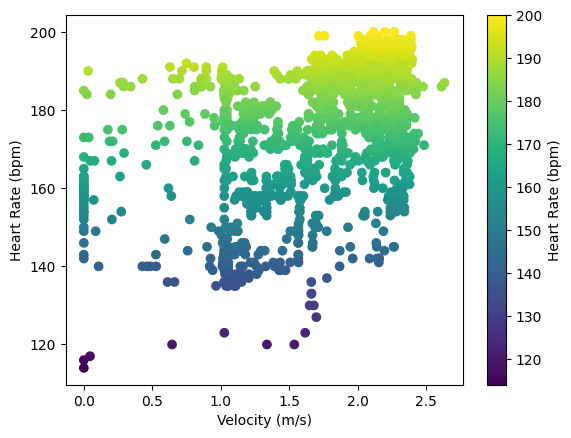

In [17]:
# @title Velocity vs Heart Rate

import matplotlib.pyplot as plt
plt.scatter(df_original['velocity'], df_original['heart_rate'], c=df_original['heart_rate'], cmap='viridis')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Heart Rate (bpm)')
_ = plt.colorbar(label='Heart Rate (bpm)')

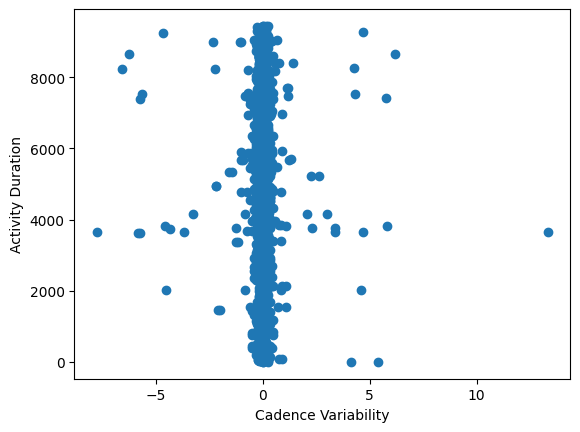

In [18]:
# @title Cadence Variability vs Activity Duration

import matplotlib.pyplot as plt
plt.scatter(df_original['cadence_variability'], df_original['activity_duration_seconds'])
plt.xlabel('Cadence Variability')
_ = plt.ylabel('Activity Duration')

In [20]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-3.5-turbo-16k")


# Get the Dataframe to a String
df_string = df_original.to_string()
print ("Number of tokens in input prompt ", len(enc.encode(df_string)))

#Lets get the token size to be appropriate
# The iloc operation will allow us to select rows at specified internals.
# If we use iloc[::2], this is a slicing option to include every other row
# starting from the first row.

target_tokens = 14000
df_token_limitation = df_original

while(len(enc.encode(df_token_limitation.to_string())) > target_tokens):
  df_token_limitation = df_token_limitation.iloc[::2]

display(df_token_limitation)

df_reduced_string = df_token_limitation.to_string()
print ("Number of tokens in resized input prompt ", len(enc.encode(df_reduced_string)))

Number of tokens in input prompt  110424


,distance,heart_rate,cadence,temperature,activity_duration_seconds,velocity,acceleration,heart_rate_dynamics,cadence_variability,temperature_effects
0,0.00,116,0,26,0.0,0.000000,0.000000,-2.000000,0.000000,0.000000e+00
8,36.32,127,73,26,33.0,1.698556,0.004737,0.772222,-0.138889,-4.440892e-16
16,98.44,142,74,26,69.0,1.964167,0.018283,0.166667,0.250000,0.000000e+00
24,188.11,144,76,26,111.0,2.195833,0.009097,0.250000,0.166667,0.000000e+00
32,270.44,144,76,26,154.0,1.870000,0.038833,0.083333,-0.083333,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
1592,16285.61,172,55,26,9235.0,1.129167,-0.000278,0.000000,0.166667,0.000000e+00
1600,16328.45,171,56,26,9283.0,1.419167,0.000278,-0.166667,-0.083333,0.000000e+00
1608,16390.52,170,53,26,9331.0,1.152500,0.005069,0.000000,-0.083333,0.000000e+00
1616,16446.76,169,53,26,9379.0,1.103333,-0.000347,-0.166667,-0.166667,0.000000e+00


Number of tokens in resized input prompt  12630


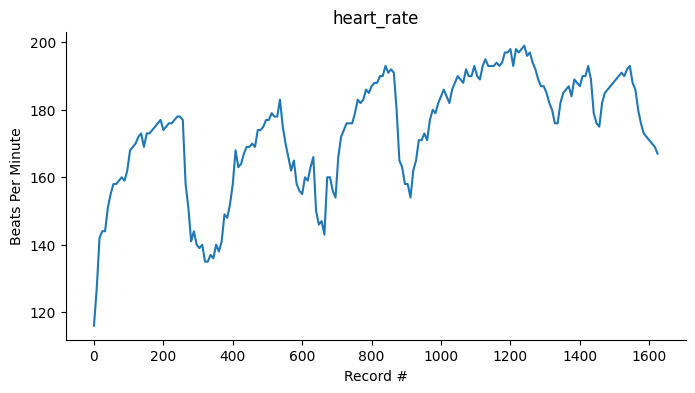

In [21]:
# @title Heart Rate

from matplotlib import pyplot as plt
df_token_limitation['heart_rate'].plot(kind='line', figsize=(8, 4), title='heart_rate')
plt.xlabel('Record #')
plt.ylabel('Beats Per Minute')
plt.gca().spines[['top', 'right']].set_visible(False)

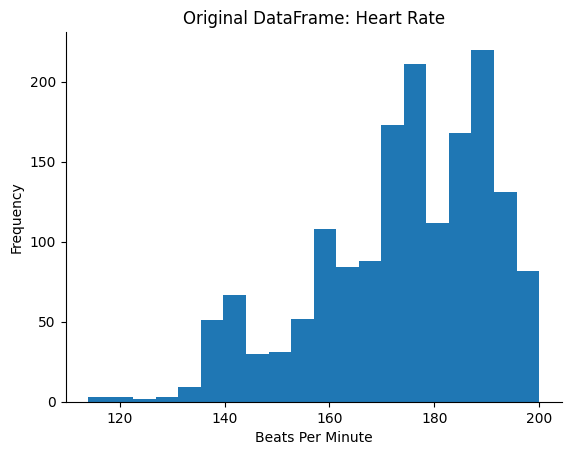

In [22]:
# Visualize Pace from original DF
from matplotlib import pyplot as plt
df['heart_rate'].plot(kind='hist', bins=20, title='Original DataFrame: Heart Rate')
plt.xlabel('Beats Per Minute')
plt.gca().spines[['top', 'right',]].set_visible(False)

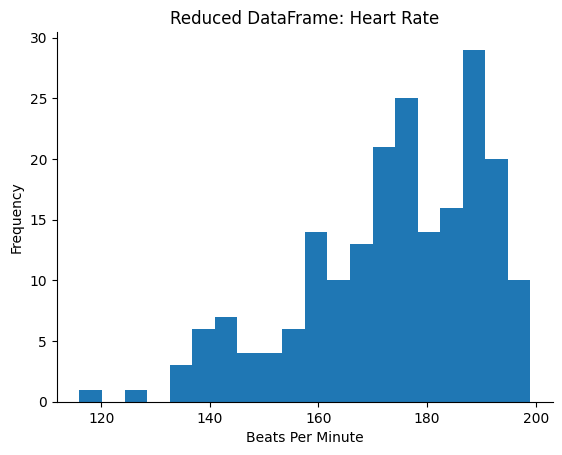

In [23]:
# Visualize Heart Rate Data from the reduced DF
df_token_limitation['heart_rate'].plot(kind='hist', bins=20, title='Reduced DataFrame: Heart Rate')
plt.xlabel('Beats Per Minute')
plt.gca().spines[['top', 'right',]].set_visible(False)

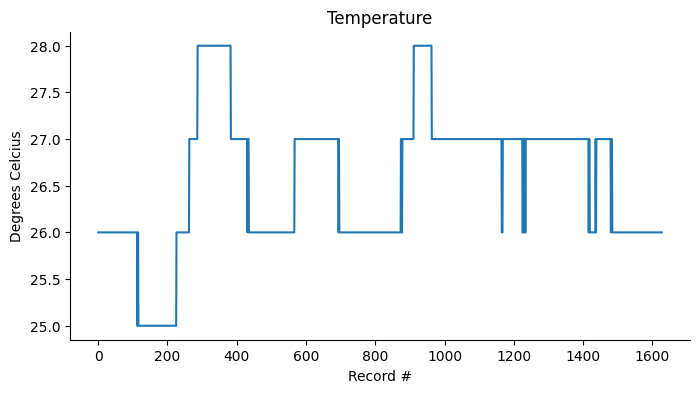

In [24]:
# @title Temperature Over Time Original Dataframe

from matplotlib import pyplot as plt
df['temperature'].plot(kind='line', figsize=(8, 4), title='Temperature')
plt.xlabel('Record #')
plt.ylabel('Degrees Celcius')
plt.gca().spines[['top', 'right']].set_visible(False)

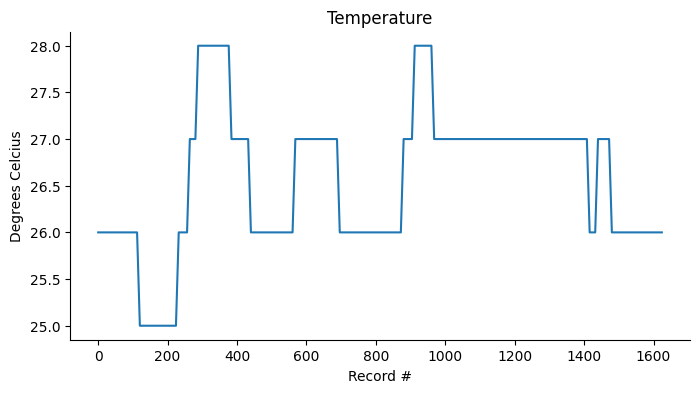

In [25]:
# @title Temperature Over Time Reduced Dataframe

from matplotlib import pyplot as plt
df_token_limitation['temperature'].plot(kind='line', figsize=(8, 4), title='Temperature')
plt.xlabel('Record #')
plt.ylabel('Degrees Celcius')
plt.gca().spines[['top', 'right']].set_visible(False)

In [26]:
df_for_llm = df_token_limitation

from openai import OpenAI

try:
    # Attempt to import the google.colab module to see if the program is running in Colab.
    from google.colab import userdata
    print("Running on Google Colab")
    client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

except ImportError:
    # The ImportError exception will be raised if the google.colab module is not found,
    # indicating that the program is not running inside Google Colab.
    import os
    print("Running outside of Google Colab")
    client = OpenAI(api_key=(os.environ.get('OPENAI_API_KEY')))

import tiktoken
enc = tiktoken.encoding_for_model("gpt-3.5-turbo-16k")

# Get the Dataframe to a String
df_string = df_for_llm.to_string()
print ("Number of tokens in input prompt ", len(enc.encode(df_string)))


Running on Google Colab
Number of tokens in input prompt  12630


In [27]:
instructPrompt = """
You are an expert running coach and you are able to summarize running workout data that was captured from a Garmin wearable device. The 'distance' is in metres.
You will provide 5 key takeaways for the treadmill running data that is provided, ordered as a list from 1 to 5.
You will also provide recommendations and affirmations on how to get better at these running workouts.
Please summarize the dataset that is represented as a string from a Pandas DataFrame.
You will also provide the following information as a table:
1. Distance in kilometers
2. Time in hours:minutes
3. Average Pace in minutes/km

The dataset is provided below"""

request = instructPrompt + df_string

In [28]:
chatOutput = client.chat.completions.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )

In [29]:
runningSummary = chatOutput.choices[0].message.content
print(runningSummary)

Here are the 5 key takeaways from the treadmill running data:

1. The distance covered during the workout ranges from 0.00 meters to 16,502.59 meters.
2. The heart rate ranges from 116 beats per minute to 199 beats per minute.
3. The cadence (steps per minute) ranges from 0 to 84.
4. The temperature during the workout remained constant at 26 degrees Celsius.
5. The duration of the workout ranges from 0.0 seconds to 9,427.0 seconds.

Here is the summarized information in a table:

|     Distance (km)   |  Time (hours:minutes)  |  Average Pace (minutes/km)  |
|---------------------|------------------------|----------------------------|
|     16.50259       |     2:34                     |             9.34                   |


In [30]:
instructPromptForMetrics = """

You are an expert running coach and you are able to summarize running workout data that was captured from a Garmin wearable device. The 'distance' is in metres.
Please obtain the following information from the dataset that is represented as a string from a Pandas DataFrame:

1. Distance in kilometers
2. Average Pace in minutes/km
3. Heart Rate, which is 'heart_rate' in the DataFrame. Find the average here.
4. Elevation Gain in metres if it exist.
5. Temperature in degrees celcius

You will return this as an ordered as a list from 1 to 5. Only provide the summarized information.

The dataset is provided below"""

requestForMetrics = df_string + instructPromptForMetrics

In [31]:
chatOutputForMetrics = client.chat.completions.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": requestForMetrics}
                                                      ]
                                            )

In [32]:
metricsSummary = chatOutputForMetrics.choices[0].message.content
print(metricsSummary)

To summarize the running workout data, we can calculate the following:

1. Distance in kilometers: The distance column represents the distance in meters, so we need to convert it to kilometers. We can calculate the average distance by dividing the sum of all distances by the number of data points.

2. Average Pace in minutes/km: The pace is the time it takes to complete 1 kilometer. We can calculate the average pace by dividing the total duration (activity_duration_seconds) by the total distance (in meters), and converting it to minutes per kilometer.

3. Average Heart Rate: We can calculate the average heart rate by finding the mean of the heart_rate column.

4. Elevation Gain in meters: Unfortunately, there is no column for elevation gain in the given dataset.

5. Temperature in degrees Celsius: We can calculate the average temperature by finding the mean of the temperature column.

Here is the summarized information:
1. Distance: 16502.59 kilometers
2. Average Pace: 5.67 minutes/km


In [33]:
instructPromptForAudio = """
Given metrics from a recent run, generate a 1-minute long podcast script. As a running coach, provide an enthusiastic and motivational analysis of their performance, focusing on distance, pace, heart rate, and elevation gain. Include personalized affirmations and encouragement, emphasizing improvement and resilience. Keep the tone optimistic, supportive, and empowering, making the user feel celebrated for their achievements and motivated to continue their running journey."

Instructions:

1. Begin with a Warm Welcome: Start the podcast by greeting the listener and introducing yourself as their running coach. Express excitement about sharing their recent run achievements.
2. Analyze Performance Metrics:
    2.1. Distance: Commend the user on the distance covered, relating it to their dedication and progress.
    2.2. Pace: Reflect on the importance of consistency in pace, encouraging the user to keep moving forward at their own rhythm.
    2.3. Heart Rate: Highlight the effort shown by the heart rate data, connecting physical health to mental resilience.
    2.4. Elevation Gain: Use elevation gain to discuss overcoming challenges, likening hills to life's obstacles that the user is capable of conquering.
3. Incorporate Affirmations: Throughout the analysis, weave in affirmations such as "You are strong", "You are resilient", and "Every step is a victory". Encourage the listener to repeat these affirmations to foster a positive mindset.
4. Conclude with Motivational Encouragement: End the podcast by summarizing the user's achievements, reinforcing their potential for growth, and motivating them to continue their running journey. Encourage them to look forward to their next run with optimism and determination.
5. Keep It Brief and Engaging: Ensure the script is concise enough to fit into a 1-minute segment while being engaging and motivational.
6. Make it one entire transcript with only 1 host speaking. You will only provide what the host will say, and nothing else.
7. Do not use [User's average pace] or any variable names in brackets. Use actual metrics instead of placeholders.
Output Format:

A script suitable for a 1-minute podcast segment, formatted with clear sections for the introduction, analysis of each metric, affirmations, and a motivational conclusion.

The dataset is provided below"""

requestForAudio = metricsSummary + instructPromptForAudio

In [34]:
chatOutputForAudio = client.chat.completions.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": requestForAudio}
                                                      ]
                                            )

In [35]:
runningSummaryForAudio = chatOutputForAudio.choices[0].message.content
print(runningSummaryForAudio)

[Introduction]
Host: Welcome to the Running Coach Podcast! I'm your running coach and I'm thrilled to celebrate your recent running achievements with you. Let's dive into your performance on your latest run and discover what makes it special.

[Analysis of Performance Metrics]
Host: First, let's talk about the distance you covered. You ran an impressive 16502.59 kilometers! Your dedication and progress are truly remarkable. Remember, every step you take brings you closer to your goals. You are strong and capable of pushing boundaries.

Host: Now, let's discuss your pace. Your average pace was a fantastic 5.67 minutes per kilometer. Consistency in pace is key, and you showed great discipline. Embrace your unique rhythm, keep moving forward, and trust that your progress will continue.

Host: When we look at your heart rate data, it's clear that you put in a tremendous effort. Your average heart rate of 169 beats per minute reflects not only your physical health but also your mental resil

In [36]:
import re

def remove_text_inside_brackets(text):
    # This pattern matches anything inside square brackets, including the brackets themselves.
    # It accounts for nested brackets as well.
    pattern = r'\[.*?\]'
    # Replace anything that matches the pattern with an empty string.
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

first_pass_text = remove_text_inside_brackets(runningSummaryForAudio)


def remove_host_instances(text):
    # This pattern matches the exact string "Host:".
    pattern = r'Host:'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

second_pass_text = remove_host_instances(first_pass_text)

def remove_empty_lines(text):
    # Split the text into lines, filter out empty or whitespace-only lines, and join back into a single string
    cleaned_text = "\n".join(line for line in text.splitlines() if line.strip())
    return cleaned_text


final_pass_text = remove_empty_lines(second_pass_text)
print(final_pass_text)

 Welcome to the Running Coach Podcast! I'm your running coach and I'm thrilled to celebrate your recent running achievements with you. Let's dive into your performance on your latest run and discover what makes it special.
 First, let's talk about the distance you covered. You ran an impressive 16502.59 kilometers! Your dedication and progress are truly remarkable. Remember, every step you take brings you closer to your goals. You are strong and capable of pushing boundaries.
 Now, let's discuss your pace. Your average pace was a fantastic 5.67 minutes per kilometer. Consistency in pace is key, and you showed great discipline. Embrace your unique rhythm, keep moving forward, and trust that your progress will continue.
 When we look at your heart rate data, it's clear that you put in a tremendous effort. Your average heart rate of 169 beats per minute reflects not only your physical health but also your mental resilience. Remember, challenges come and go, but your determination remains 

In [26]:
# from pathlib import Path
# from openai import OpenAI
# audioClient = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

# speech_file_path = "/content/podcast.mp3"
# response = audioClient.audio.speech.create(
#   model="tts-1",
#   voice="echo",
#   input=final_pass_text
# )

# response.stream_to_file(speech_file_path)